# All

## Import/read

In [ ]:
import os
import pickle
import time
import warnings
from copy import deepcopy
from datetime import datetime
from itertools import repeat
from types import SimpleNamespace
from typing import Callable

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import (
    BayesianOptimization,
    SequentialDomainReductionTransformer,
    UtilityFunction,
)
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from library.utils import read_df, states, states_abb, write_df
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from traitlets import (
    Any,
    Bool,
    Callable,
    Dict,
    Float,
    HasTraits,
    Int,
    List,
    TraitError,
    TraitType,
    Tuple,
    Unicode,
    default,
    validate,
)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [ ]:
# data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"
# bayesian_run_path = "../data/bayesian_runs/"


# def read_file(filename, sub_folder="kaggle", delimiter=","):
#     df = pd.read_csv(os.path.join(data_path, sub_folder, filename), delimiter=delimiter)

#     if filename == "train.csv":
#         df_revealed_test = read_file("revealed_test.csv")
#         return (
#             pd.concat([df, df_revealed_test], axis=0)
#             .sort_values(["cfips", "first_day_of_month"])
#             .reset_index(drop=True)
#         )
#     return df

In [ ]:
df_census = read_df("census_starter.csv")
df_test = read_df("test.csv")
df_train = read_df("train.csv")
df_submission = read_df("sample_submission.csv")
# df_population = read_df('df_population.csv', 'other')
# df_census_population = read_df('df_census_population.csv', 'kaggle_census')
# df_train_census = read_df('df_train_census.csv', 'kaggle_census')
df_adjusted_microbusiness_density = read_df('df_adjusted_microbusiness_density.csv', 'kaggle_census')

# df_boundaries = read_df("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")
df_train = pd.merge(df_train, df_adjusted_microbusiness_density, 'left', 'row_id')
df_train = df_train.rename(
    columns={
        "microbusiness_density": "original_microbusiness_density",
        "adjusted_microbusiness_density": "microbusiness_density",
    }
)

### Add census, year, fix dates etc

In [ ]:
def fix_df_train(df_train):
    df = df_train.copy()

    # Add year
    df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])
    df["year"] = df["first_day_of_month"].dt.year.astype(int)

    # Add df_census to df
    cols = list(df_census.columns)
    cols.remove("cfips")

    t0 = df_census.melt("cfips", cols)
    t0["year"] = t0["variable"].str.split("_").str[-1].astype(int)
    t0["variable_name"] = t0["variable"].str.rsplit("_", expand=False, n=1).str[0]

    t1 = pd.pivot_table(t0, "value", ["cfips", "year"], "variable_name").reset_index()

    # Census data is lagging 2 years
    t1["year"] = t1["year"] + 2

    df = pd.merge(df, t1, "left", left_on=["cfips", "year"], right_on=["cfips", "year"])

    # Add month
    df["month"] = df["first_day_of_month"].dt.month

    return df

In [ ]:
# df_train = fix_df_train(df_train)

t = df_train[df_train.isna().any(axis=1)]
if t.shape[0] != 24:
    raise Exception("Nan counts used to be 24... something changed")

In [ ]:
df_train[df_train.isna().any(axis=1)].shape

### Weather save/load

In [ ]:
def save_weather_data(path_weather):
    # Temperatures
    temps = df_boundaries[["NAME", "NAMELSAD", "INTPTLAT", "INTPTLON"]].copy()
    temps["min_date"] = df_train["first_day_of_month"].min()
    temps["max_date"] = df_train["first_day_of_month"].max()

    data_list = []
    for idx, row in temps.iterrows():
        p = Point(row["INTPTLAT"], row["INTPTLON"], 70)

        data = Monthly(p, row["min_date"], row["max_date"])
        data = data.fetch()

        if data.shape[0] > 0:
            data["state"] = row["NAME"]
            data["county"] = row["NAMELSAD"]

            data_list.append(data)

        if idx % 100 == 0:
            print(idx)

    weather_data = pd.concat(data_list)
    weather_data.to_csv(path_weather)

In [ ]:
path_weather = "../data/other/weather/weather.csv"
# save_weather_data(path_weather)

In [ ]:
df_weather = pd.read_csv(path_weather)

### Baseline model

#### Feature functions

In [ ]:
def _loop_new_cols(
    df: pd.DataFrame, df_mapped_feature: pd.DataFrame, f: callable,target_col:str, groupby_col: str
) -> pd.DataFrame:
    res = []
    for idx, row in df_mapped_feature.iterrows():
        r = f(df, idx, target_col, groupby_col, int(row["params"]))
        res.append(r)

    return pd.concat(res, axis=1)

def f_rolling_mean(
    df: pd.DataFrame,
    df_mapped_feature: pd.DataFrame,
    target_col: str,
    f_col: str,
    groupby_col: str,
    **kwargs
):
    def _f(df: pd.DataFrame, col: str, target_col: str, groupby_col: str, window: int):
        # if window < 1:
        #     print('Window is', window,' - Setting window to 1')
        #     window = 1
        assert window > 0, "Window has to be above 0"
        rolling_mean = (
            df.sort_values([groupby_col, "first_day_of_month"])
            .groupby([groupby_col])[target_col]
            .rolling(window, closed="left")
            .mean()
            .rename(col)
            .reset_index(drop=True)
        )
        rolling_mean.index = df["row_id"]

        return rolling_mean

    return _loop_new_cols(df, df_mapped_feature, _f, target_col, groupby_col)

def f_shifted(df: pd.DataFrame, col: str, shift: int) -> pd.DataFrame:
    # if window < 1:
    #     print('Window is', window,' - Setting window to 1')
    #     window = 1
    assert shift >= 1, "lower shift leads to leakage of target variable"
    shifted = (
        df.sort_values(["cfips", "first_day_of_month"])
        .groupby(["cfips"])[target_col]
        .shift(shift)
        .rename(col)
        .reset_index(drop=True)
    )
    shifted.index = df["row_id"]

    return shifted

In [ ]:
def add_feature_targets_history(
    df: pd.DataFrame, df_mapped_feature: pd.DataFrame, f_col: str, **kwargs
) -> (str, pd.DataFrame):
    """
    Add rolling windows and/or shifted values

    window: list
        List of windows to add. [2, 5] will add two columns with rolling window 2 and 5.
    shifts: list
        List of recents shifts to add. [2, 5] will add two columns with shifts of 2 and 5.
    """

    def add_rolling_mean_x(df: pd.DataFrame, col: str, window: int) -> pd.DataFrame:
        assert window > 0, "Window has to be above 0"
        rolling_mean = (
            df.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])[target_col]
            .rolling(window, closed="left")
            .mean()
            .rename(col)
            .reset_index(drop=True)
        )
        rolling_mean.index = df["row_id"]

        return rolling_mean

    def add_shifted_x(df: pd.DataFrame, col: str, shift: int) -> pd.DataFrame:
        assert shift >= 1, "lower shift leads to leakage of target variable"
        shifted = (
            df.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])[target_col]
            .shift(shift)
            .rename(col)
            .reset_index(drop=True)
        )
        shifted.index = df["row_id"]

        return shifted

    def _loop_new_cols(
        df: pd.DataFrame, df_mapped_feature: pd.DataFrame, f: callable
    ) -> pd.DataFrame:
        res = []
        for idx, row in df_mapped_feature.iterrows():
            r = f(df, idx, int(row["params"]))
            res.append(r)

        return pd.concat(res, axis=1)

    # global _df
    # _df = df_mapped_feature

    if f_col == "target_rolling_mean":
        return _loop_new_cols(df, df_mapped_feature, add_rolling_mean_x)
    elif f_col == "target_shift":
        return _loop_new_cols(df, df_mapped_feature, add_shifted_x)
    else:
        raise ValueError("f_col ´{f_col}´ is not supported")

In [ ]:
def add_categorical_feature(df: pd.DataFrame, f_col: str, **kwargs):
    return df[['row_id', f_col]].set_index('row_id').astype('category')

def add_numerical_feature(df: pd.DataFrame, f_col: str, **kwargs):
    return df[['row_id', f_col]].set_index('row_id')

def time_arrow(df: pd.DataFrame, f_col: str, **kwargs):
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    seconds_since = df["first_day_of_month"].astype("int64") // 1e9
    df[f_col] = NormalizeData(seconds_since)

    return df[['row_id', f_col]].set_index('row_id')

In [ ]:
def add_feature_targets_groupby_stats(
    df,
    f_col,
    # new_col_template="{}_target_{}",
    agg_function=None,
    # agg_functions=["mean", "std", "median"],
    train_idx=None,
    col=None,
    **kwargs
):
    df = df.copy()
    t0 = df.groupby(col)["microbusiness_density"].agg(agg_function)
    t0 = t0.rename(f_col)

    df = pd.merge(df, t0, "left", left_on=col, right_index=True).set_index('row_id')
    return pd.DataFrame(df[f_col])

In [ ]:
def correlated_states(df_train):
    """
    Find states that correlate well in terms of change in ´microbusiness_density´
    """
    cols_state_relation = []
    dfs = pd.DataFrame([])
    new_col_raw = "mean"

    # Rolling
    t0 = (
        df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    t1 = t0.pivot_table(new_col_raw, "first_day_of_month", "state").sort_index().corr()
    # plt.imshow(t1.values, cmap="hot", interpolation="nearest")
    # plt.show()

    t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
    t5 = t5[t5["state"] != t5["other_state"]]

    # Clean pairs of same correlations
    t5 = t5.sort_values("corr").reset_index(drop=True)
    cols = ["state", "other_state"]
    t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
    t5 = t5.drop_duplicates()

    # Cluster
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))
    t5["cluster"] = clustering.labels_

    # Iterate through pairs and add state means to each other
    corr_states = t5[abs(t5["corr"]) > 0.9]

    # Append one month.
    t2 = df_train.copy()
    t2["first_day_of_month"] = t2["first_day_of_month"] + pd.DateOffset(months=1)
    t0 = (
        t2.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    # Iterate over the pairs
    for pair in corr_states.values:
        group = pair[:2]
        corr = pair[2]

        switched = t0[t0["state"].isin(group)].copy()

        state_0 = group[0]
        state_1 = group[1]

        s = "{}_{}_rolling_microbusiness_density"
        col_state_0 = s.format(state_0, state_1)
        col_state_1 = s.format(state_1, state_0)

        sw = pd.pivot_table(
            switched, new_col_raw, "first_day_of_month", "state"
        ).rename(columns={state_0: col_state_0, state_1: col_state_1})

        def boo(df, sw, state, col_state, corr):
            """
            I think it switches state labels.
            """
            corr_col = "corr_" + col_state
            # sw[corr_col] = corr

            df_state_t = sw[[col_state]].reset_index()
            df_state_t["state"] = state

            # df = pd.merge(
            #     df,
            #     df_state_t,
            #     "left",
            # left_on=["state", "first_day_of_month"],
            # right_on=["state", "first_day_of_month"],
            # )

            return (df_state_t, corr_col)

        df_state_t_0, corr_col_0 = boo(df_train, sw, state_1, col_state_0, corr)
        df_state_t_1, corr_col_1 = boo(df_train, sw, state_0, col_state_1, corr)

        # Append results to list
        if dfs.shape[0] == 0:
            dfs = pd.merge(
                df_state_t_0,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        else:
            dfs = pd.merge(
                dfs,
                df_state_t_0,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
            dfs = pd.merge(
                dfs,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        # cols_state_relation.extend([corr_col_0, corr_col_1])
        cols_state_relation.extend([col_state_0, col_state_1])

    return (dfs, cols_state_relation)

In [ ]:
def state_cluster(df_train):
    t0 = df_train.groupby("state")["microbusiness_density"].agg(["mean", "std"])
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(t0.values)
    t0["cluster"] = clustering.labels_

    return t0.reset_index()[["state", "cluster"]]

##### Maybe pile

In [ ]:
def ups_downs(df_train):
    """
    Counts ups and downs until the latest known time. Returns the percetage of ups/downs
    """
    col = "microbusiness_shift_bool_over_pct"
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    added_feature_cols.append(col)

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

#### Misc functions

In [ ]:

# def remove_outliers(train, outlier_multiplier):
#     """
#     Remove outlies. Should be run on train only
#     """
#     max_density = (
#         train.groupby("cfips")["microbusiness_density"]
#         .mean()
#         .rename("max_microbusiness_density")
#         .reset_index()
#     )
#     max_density["max_microbusiness_density"] = (
#         max_density["max_microbusiness_density"] * outlier_multiplier
#     )
#     t1 = pd.merge(
#         train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
#     )

#     idx = t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]
#     t = train.loc[idx].copy()

#     return t


def smape(pred, eval_data):
    if hasattr(eval_data, "label"):
        A = eval_data.label  # Used by lightgbm
    else:
        A = eval_data  # Used by numpy
    F = pred

    if type(pred) == int or type(pred) == float:
        # Single cases
        value = 100 / 1 * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    else:
        # Many cases
        value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False


def remove_empty_folders(path_abs):
    walk = list(os.walk(path_abs))
    for path, _, _ in walk[::-1]:
        if len(os.listdir(path)) == 0:
            os.rmdir(path)


def save_bayesian_results(loss_fn: str, results: list[dict], best: dict):
    def save_pkl(full_path, data):
        with open(full_path, "wb") as f:
            pickle.dump(data, f)

    # Create folders
    dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    subfolder = "{}_{}".format(dt, abs(round(best["target"], 4)))
    bay_result_dir = os.path.join(bayesian_run_path, loss_fn, subfolder)

    if not os.path.exists(bay_result_dir):
        os.makedirs(bay_result_dir)

    # Full paths
    result_path = os.path.join(bay_result_dir, "result.pkl")
    best_path = os.path.join(bay_result_dir, "best.pkl")

    # Save pickles
    save_pkl(result_path, results)
    save_pkl(best_path, best)

    # Remove empty folders that can trash the place
    remove_empty_folders(bayesian_run_path)


def read_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

## Train

### Column mapping

#### Progress

In [ ]:
def cell_vars(offset=0):
    
    def filter_feature_class_only(result):
        feature_class_only = {}
        for key, val in result.items():
            if str(type(val)) == "<class '__main__.Feature'>":
                feature_class_only.update({key:val})
                
        return feature_class_only
    
    import io
    from contextlib import redirect_stdout

    ipy = get_ipython()
    out = io.StringIO()

    with redirect_stdout(out):
        ipy.magic("history {0}".format(ipy.execution_count - offset))

    #process each line...
    x = out.getvalue().replace(" ", "").split("\n")
    x = [a.split("=")[0] for a in x if "=" in a] #all of the variables in the cell
    g = globals()
    result = {k:g[k] for k in x if k in g}
    
    feature_class_only = filter_feature_class_only(result)
    
    if len(feature_class_only) == 0:
        raise ValueError('None found. Maybe you changed name AGAIN?')
    
    return feature_class_only

In [ ]:
class DataFrame(TraitType):
    """A trait for pd.DataFrame."""

    info_text = "pd.DataFrame"

    def validate(self, obj, value):
        if type(value) == pd.DataFrame:
            return value
        self.error(obj, value)


class Feature(HasTraits):
    # During init

    f_col = Unicode()
    f = Callable()

    bound = Tuple(Float(), Float())

    enabled_bounds = List(bound, minlen=1)
    params_bounds = List(bound)

    # After init

    _enabled_dict = Dict(key_trait=Unicode(), value_trait=bound)
    _params_dict = Dict(key_trait=Unicode(), value_trait=bound)

    relations = Dict(key_trait=Unicode(), value_trait=Unicode())

    _df_enabled_params = DataFrame()

    def __init__(self, f_col, f, df, enabled_bounds=None, params_bounds=None, **kwargs):
        self.f_col = f_col
        self.f = f
        self.df = df
        if enabled_bounds:
            self.enabled_bounds = enabled_bounds
        if params_bounds:
            self.params_bounds = params_bounds

        self._add_self_to_global_feature_objects()
        self._make_enable_and_params_dict()
        self._make_df_enable_params()
        
        self._kwargs = kwargs

    def get_relations(self):
        return self._relations

    def get_enabled_dict(self):
        return self._enabled_dict

    def get_params_dict(self):
        return self._params_dict

    def get_df_enable_params(self):
        return self._df_enabled_params

    def _add_self_to_global_feature_objects(self):
        """
        This global list is used to pick up features by ´ManageFeatures´
        """
        global feature_objects
        feature_objects[self.f_col] = self
    
    def _set_relations(self, d):
        self._relations = d

    def _make_df_enable_params(self):
        d = self.get_relations()
        relation_original = d
        relation_flipped = {v: k for k, v in d.items()}

        # Get relations
        df_relation = pd.DataFrame.from_dict(
            {**relation_original, **relation_flipped},
            orient="index",
            columns=["relation"],
        )

        # Bounds
        df_bounds = pd.DataFrame.from_dict(
            {
                **self._enabled_dict,
                **self._params_dict,
            },
            orient="index",
            columns=["min", "max"],
        )

        # Kind column separating enabled/params
        df_bounds.loc[self._enabled_dict.keys(), "kind"] = "enabled"
        df_bounds.loc[self._params_dict.keys(), "kind"] = "params"

        # Join
        df = pd.merge(df_bounds, df_relation, "left", left_index=True, right_index=True)

        # Add f_col
        df["f_col"] = self.f_col

        # Fill relations where there are none 
        # when feature has no params, but bayes wants to switch it on/off
        
        df['relation'] = df['relation'].fillna(df.index.to_series())

        self._df_enabled_params = df

    def _make_enable_and_params_dict(self):
        """
        Create 2 variables:
        1) self._enabled_dict
        2) self._params_dict
        """
        self._enabled_keys = []
        self._params_keys = []
        for kind in ["enabled", "params"]:
            bounds = getattr(self, "{}_bounds".format(kind))

            d = {}
            key_f_col = "{kind}_{f_col}_{idx}"
            for idx, bound in enumerate(bounds):
                if len(bounds) < 2:
                    idx = ""
                key = key_f_col.format(kind=kind, f_col=self.f_col, idx=idx)
                d[key] = bound

                getattr(self, "_{}_keys".format(kind)).append(key)

            setattr(self, "_{}_dict".format(kind), d)
        # Set relations for all
        d = dict(zip(self._enabled_keys, self._params_keys))
        self._set_relations(d)

    @default("enabled_bounds")
    def _default_value(self):
        return [(0, 1)]

    @validate("params_bounds")
    def _valid_params_bounds(self, proposal):
        params_bounds = proposal["value"]

        if params_bounds is not None:
            len_params_bounds = len(params_bounds)
            len_enabled_bounds = len(self.enabled_bounds)
            if len_params_bounds != len_enabled_bounds:
                raise TraitError(
                    "If defined, ´params_bounds´ ({}) should match in length with ´enabled_bounds´ ({})".format(
                        len_params_bounds, len_enabled_bounds
                    )
                )

        return proposal["value"]

    @validate("enabled_dict")
    def _valid_enabled_dict(self, proposal):
        for key, value in proposal["value"].items():
            bound_min = value[0]
            bound_max = value[1]

            if (bound_min < 0 or bound_min > 1) or (bound_max < 0 or bound_max > 1):
                raise TraitError(
                    "For key ´{}´ bound values have to be between 0 and 1 (both included). Values given: ´{}´".format(
                        key, value
                    )
                )

            if bound_min > bound_max:
                raise TraitError(
                    "Bound min cannot be bigger than max. Values given: ´{}´".format(
                        value
                    )
                )

        return proposal["value"]

In [ ]:
class ManageFeatures(HasTraits):
    _feature_objects = Dict(key_trait=Unicode())
    _df_enabled_params = DataFrame()
    _enabled_keys = List(Unicode())
    _model_pbounds = Dict(key_trait=Unicode(), value_trait=Tuple(Float(), Float()))

    def __init__(self, feature_objects):
        self._feature_objects = feature_objects
        # self._target_col = target_col

        self._set_enabled_keys()
        self._set_features_df_enabled_params()

    def set_model_pbounds(self, model_pbounds: dict):
        self._model_pbounds = model_pbounds

    def get_model_params(self, bay_params):
        model_params = {k: v for k, v in bay_params.items() if k in self._model_pbounds}

        model_params["num_iterations"] = round(model_params["num_iterations"])
        model_params["num_leaves"] = round(model_params["num_leaves"])
        model_params['bagging_freq'] = int(np.round(model_params['bagging_freq']))
        model_params['max_depth'] = int(np.round(model_params['max_depth']))
        model_params['min_data_in_leaf'] = int(np.round(model_params['min_data_in_leaf']))
        
        for key, _tuple in self._model_pbounds.items():
            if model_params[key] < _tuple[0]:
                model_params[key] = _tuple[0]
            if model_params[key] > _tuple[1]:
                model_params[key] = _tuple[1]

        return model_params

    def get_pbounds(self):
        df = self._get_features_df_enabled_params()
        df["pbounds"] = list(zip(df["min"], df["max"]))

        return {**self._model_pbounds, **df["pbounds"].to_dict()}

    def generate_features(self, bay_params: dict):
        # Remove model_pbounds
        bay_params = {
            k: v for k, v in bay_params.items() if k not in self._model_pbounds
        }

        df_mapped = self.get_params(bay_params)

        res = []
        for feature in self._iter_feature_objects():
            df_mapped_feature = df_mapped[df_mapped["f_col"] == feature.f_col]

            # Some features are used, some not
            if df_mapped_feature.shape[0] != 0:
                r = feature.f(
                    df=feature.df.copy(),
                    df_mapped_feature=df_mapped_feature,
                    f_col=feature.f_col,
                    **feature._kwargs
                )

                assert (
                    r.index.name == "row_id"
                ), "All features need to have ´row_id´ as index"

                res.append(r)
        df_features = pd.concat(res, axis=1)

        return df_features

    def generate_target(self, df_train: pd.DataFrame, shift=0):
        t0 = (
            df_train.sort_values(["cfips", "first_day_of_month"])
            .groupby("cfips")["microbusiness_density"]
            .shift(shift)
        )

        t0.index = df_train["row_id"]

        return t0

    def get_params(self, bay_params: dict):
        # Mapping for columns
        df_mapped = self.get_mapping(bay_params)

        # Params
        idx_params = df_mapped[
            (df_mapped["kind"] == "enabled") & (df_mapped["params"] > 0.5)
        ]["relation"]
        df_params = df_mapped[df_mapped.index.isin(idx_params)]

        return df_params

    def get_mapping(self, bay_params: dict):
        df_enabled_params = self._get_features_df_enabled_params()
        df_bay_params = pd.DataFrame.from_dict(
            bay_params, orient="index", columns=["params"]
        )

        df = pd.merge(
            df_enabled_params, df_bay_params, "outer", left_index=True, right_index=True
        )

        assert (
            df.shape == df.dropna(subset=["pbounds", "params"]).shape
        ), "There should be no NaN values"

        return df

    def _set_enabled_keys(self):
        l = []
        for key, value in self._feature_objects.items():
            l.extend(value._enabled_keys)

        self._enabled_keys = l

    def _get_features_df_enabled_params(self):
        return self._df_enabled_params

    def _set_features_df_enabled_params(self, f="get_df_enable_params"):
        l = []
        # for key, obj in self._feature_objects.items():
        for feature in self._iter_feature_objects():
            l.append(getattr(feature, f)())

        self._df_enabled_params = self._validate_df_duplicate_index_and_concat(l)

    def _validate_df_duplicate_index_and_concat(self, l):
        rows_in_l = 0
        for t in l:
            rows_in_l += t.shape[0]

        df = pd.concat(l)

        assert (
            rows_in_l == df.shape[0]
        ), "Row count should be same. You probably have a duplicate index between diferent ´Feature objects´"

        return df

    def _iter_feature_objects(self) -> Feature:
        for key, obj in self._feature_objects.items():
            yield obj

In [99]:
class ManageDataSplit:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy().set_index("row_id")

        self._train_idx = None
        self._val_idx = None
        self._test_idx = None

        self._set_split_idx()

    def split_data(self, df_features: pd.DataFrame, df_target: pd.DataFrame, objective: str) -> dict:
        idx_wo_nan = df_features.dropna().index.intersection(df_target.dropna().index)

        # Filter with filterin nan rows
        train_filter = (df_features.index.isin(self._train_idx)) & (
            df_features.index.isin(idx_wo_nan)
        )
        val_filter = (df_features.index.isin(self._val_idx)) & (
            df_features.index.isin(idx_wo_nan)
        )
        test_filter = (df_features.index.isin(self._test_idx)) & (
            df_features.index.isin(idx_wo_nan)
        )

        self.constant = 1
        if objective == 'mape':
            self.constant = 1
        
        return {
            "train": {
                "data": df_features[train_filter],
                "label": df_target[train_filter],
            },
            "val": {
                "data": df_features[val_filter],
                "label": df_target[val_filter],
            },
            "test": {
                "data": df_features[test_filter],
                "label": df_target[test_filter],
            },
        }

    def get_model_input(
        self, manage_features: ManageFeatures, df_train, objective=None, bayes_kwargs: dict=None
    ):
        df_features = manage_features.generate_features(bayes_kwargs)
        df_target = manage_features.generate_target(df_train)

        dict_split_df = self.split_data(df_features, df_target, objective)

        lgb_train = lgb.Dataset(**dict_split_df["train"], free_raw_data=False)
        lgb_eval = lgb.Dataset(
            **dict_split_df["val"], reference=lgb_train, free_raw_data=False
        )
        lgb_test = lgb.Dataset(
            **dict_split_df["test"], reference=lgb_train, free_raw_data=False
        )

        model_params = manage_features.get_model_params(bayes_kwargs)

        return (lgb_train, lgb_eval, lgb_test, model_params)

    def get_train_data(self):
        return self.df.loc[self._train_idx]
    
    def _set_split_idx(
        self,
        train_size: float = 0.70,
        val_size: float = 0.20,
        test_size: float = 0.10,
        date_col: str = "first_day_of_month",
    ):
        dates = np.sort(self.df[date_col].unique())

        dates_idx_train_end = int(dates.shape[0] * train_size)
        dates_idx_val_end = int(dates.shape[0] * (train_size + val_size))

        dates_train = dates[0:dates_idx_train_end]
        dates_val = dates[dates_idx_train_end:dates_idx_val_end]
        dates_test = dates[dates_idx_val_end:]

        self._train_idx = self.df[self.df[date_col].isin(dates_train)].index
        self._val_idx = self.df[self.df[date_col].isin(dates_val)].index
        self._test_idx = self.df[self.df[date_col].isin(dates_test)].index

In [100]:
# recorded_evaluations = {}
def build_callbacks(
    early_stopping: int = 0, log_evaluation: int = 0, record_evaluation: dict = None
):
    callbacks = []

    # Stop earlier if no changes
    if early_stopping:
        callbacks.append(
            lgb.early_stopping(early_stopping, first_metric_only=True, verbose=False)
        )

    # Log every X-th line
    if log_evaluation:
        callbacks.append(lgb.log_evaluation(log_evaluation))

    if record_evaluation is not None:
        assert (
            type(record_evaluation) == dict
        ), "´record_evaluation´ has to be dictionary"
        callbacks.append(lgb.record_evaluation(record_evaluation))

    return callbacks

In [101]:
from itertools import repeat

manage_data_split = ManageDataSplit(df_train)

feature_objects = {}
enabled_tuple = (0, 0.9)
allways_enabled_tuple = (1, 1)
params_tuple = (0, 10)
    
for cols in [
    {'target_col': "microbusiness_density", 'groupby_col': 'cfips'},
    {'target_col': "microbusiness_density", 'groupby_col': 'county'},
    {'target_col': "microbusiness_density", 'groupby_col': 'state'},
]:
    target_col = cols['target_col']
    groupby_col = cols['groupby_col']
    f_col = "{}_{}_rolling_mean".format(groupby_col, target_col)
    feature_target_rolling_mean = Feature(
        f_col,
        f_rolling_mean,
        df_train,
        target_col=target_col,
        groupby_col=groupby_col,
        enabled_bounds=list(repeat(enabled_tuple, 4)),
        params_bounds=list(repeat((1, 10), 4)),
    )

feature_target_shift_mean = Feature(
    "target_shift",
    add_feature_targets_history,
    df_train,
    enabled_bounds=list(repeat(enabled_tuple, 4)),
    params_bounds=list(repeat((1, 10), 4)),
)

for idx, col in enumerate(
    [
        "county",
        "state",
        "cfips",
    ]
):
    _feature = Feature(
        col, add_categorical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

for idx, col in enumerate(
    [
        "median_hh_inc",
        "pct_bb",
        "pct_college",
        "pct_foreign_born",
        "pct_it_workers",
    ]
):
    _feature = Feature(
        col, add_numerical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

feature_time_arrow = Feature(
    "time_arrow", time_arrow, df_train, enabled_bounds=[enabled_tuple]
)

for col in [
    "cfips",
    "state",
    "county",
    "median_hh_inc",
    "pct_bb",
    "pct_college",
    "pct_foreign_born",
    "pct_it_workers",
]:
    for agg_function in ["median", "mean", "std"]:
        f_col = new_col_template = "{}_target_{}".format(col, agg_function)
        _feature = Feature(
            f_col,
            add_feature_targets_groupby_stats,
            df_train,
            col=col,
            agg_function=agg_function,
            enabled_bounds=[enabled_tuple],
            train_idx=manage_data_split._train_idx,
        )

# Bounded region of parameter space
model_pbounds = {
    "num_leaves": (3, 200),
    "num_iterations": (200, 2000),
    "learning_rate": (0.1, 2),
    # "learning_rate": (0.01, 2),
    "bagging_fraction": (0.01, 1),
    "feature_fraction": (0.01, 1),
    "lambda_l1": (0, 100),
    "lambda_l2": (0, 100),
    "bagging_freq": (0, 100),
    "min_data_in_leaf": (10, 3000),
    "min_sum_hessian_in_leaf": (0, 10),
    "max_depth": (-10, 100),
    "path_smooth": (0, 50)
}

In [110]:
objective='mae'
def optimize_this(objective=objective, return_booster=False, **bayes_kwargs):
    
    # Make sure bayes_kwargs are inside the bounds
    pbounds = manage_features.get_pbounds()
    for key, _tuple in pbounds.items():
        params = bayes_kwargs
        if params[key] < _tuple[0]:
            # print(params[key], _tuple)
            params[key] = _tuple[0]
        if params[key] > _tuple[1]:
            # print(params[key], _tuple)
            params[key] = _tuple[1]
            
    # print(params)
    # print(bayes_kwargs)
    
    lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
        manage_features, df_train, objective=objective, bayes_kwargs=bayes_kwargs
    )

    # callbacks = build_callbacks()
    callbacks = build_callbacks(early_stopping=300)

    model_params = {
        **model_params,
        **{
            "boosting_type": "gbdt",
            # "objective": "mae",
            "objective": objective,
            "metric": "None",
            "first_metric_only": True,
            "num_threads": 6,
            "verbose": -1,
        },
    }
    
    # print(model_params)

    # Can be used to supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
    
        gbm = lgb.train(
            model_params,
            lgb_train,
            callbacks=callbacks,
            valid_sets=[lgb_eval],
            feval=smape,
        )
        
        
        pred = gbm.predict(lgb_test.data)
        loss = smape(pred, lgb_test.label)
        
#         print(loss, objective, gbm.best_score)
        if return_booster:
            return (gbm, lgb_train, lgb_eval, lgb_test)
        else:
            # print(objective, -gbm.best_score["valid_0"]["smape"])
            print(objective, -loss[1], -gbm.best_score["valid_0"]["smape"])
            # return -gbm.best_score["valid_0"]["smape"]
            return -loss[1]

In [111]:
manage_data_split._train_idx.shape

(87780,)

In [112]:
manage_data_split._val_idx.shape

(25080,)

##### Train

In [ ]:
manage_features = ManageFeatures(feature_objects)
manage_features.set_model_pbounds(model_pbounds)

pbounds = manage_features.get_pbounds()

acquisition_function = UtilityFunction(kind="ucb")
# acquisition_function = UtilityFunction(kind="ucb", kappa=1)
bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)
optimizer = BayesianOptimization(
    f=optimize_this,
    pbounds=pbounds,
    verbose=1,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=5,
    bounds_transformer=bounds_transformer
)
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=10)

# load_logs(optimizer, logs=["../data/bayesian_optimizer/{}_logs.json".format(dt)]);

dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

logger = JSONLogger(path="../data/bayesian_optimizer/{}_logs.json".format(dt))
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# objective='mape'
optimizer.maximize(
    init_points=100,
    n_iter=2000,
    # acquisition_function=acquisition_function
)

print(optimizer.max['target'])

mae -13.16616538660461 -13.025959903919736
mae -8.803406263631448 -8.426266958493237
mae -15.768583771203486 -14.777254247133024
mae -8.925322014635094 -8.55376987429314
mae -7.995640939420662 -7.936120555947788
mae -6.231179019997205 -5.606053233703171
mae -9.486505694625139 -9.245439084279285
mae -10.376784462443252 -10.464043731631008
mae -5.546175101767499 -5.481635597538351
mae -4.909471021898301 -4.895637484369105
mae -47.488279117866334 -47.424836737777746
mae -12.876050183890117 -12.841178035490175
mae -5.100683937325239 -4.979227835852726
mae -43.58878782278321 -43.164939943355876
mae -6.63435773874391 -6.373249583449458
mae -54.255934552353885 -72.38027757427562
mae -3.3471967126047133 -3.39865917933295
mae -5.355255805483735 -4.813641096573859
mae -4.960426506952186 -4.716446734511956
mae -4.122330372750598 -4.237212751064926
mae -11.511672643053078 -10.864323786683842
mae -6.268589076131072 -5.718940763235421
mae -5.455187606378971 -5.435446674717968
mae -5.1217511546916095

<Axes: >

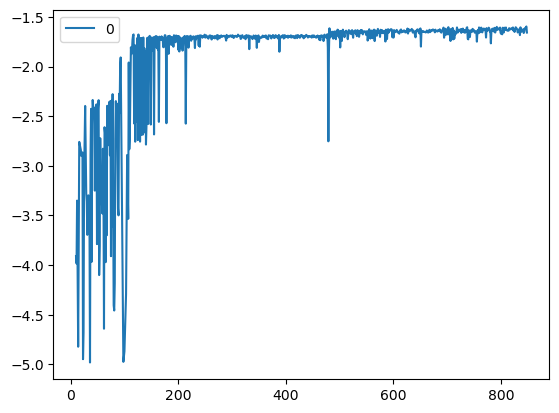

In [84]:
df_optimizer = pd.DataFrame([x['target'] for x in optimizer.res])
df_optimizer[df_optimizer[0] > -5].plot()

In [86]:
df_optimizer.max()

0   -1.595836
dtype: float64

In [ ]:
# def remove_outliers(df, f_col, train_idx):
#     """
#     Remove outlies. Should be run on train only
#     """
#     max_density = (
#         train.groupby("cfips")["microbusiness_density"]
#         .mean()
#         .rename("max_microbusiness_density")
#         .reset_index()
#     )
#     max_density["max_microbusiness_density"] = (
#         max_density["max_microbusiness_density"] * outlier_multiplier
#     )
#     t1 = pd.merge(
#         train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
#     )

#     idx = t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]
#     t = train.loc[idx].copy()

#     return t

In [ ]:
optimizer.max['params']

In [87]:
optimizer.max['params']

{'bagging_fraction': 1.25,
 'bagging_freq': 2.5690274845126955,
 'enabled_cfips_': 0.23360154359839588,
 'enabled_cfips_microbusiness_density_rolling_mean_0': -0.25421161299859313,
 'enabled_cfips_microbusiness_density_rolling_mean_1': 1.15,
 'enabled_cfips_microbusiness_density_rolling_mean_2': -0.3904145951255782,
 'enabled_cfips_microbusiness_density_rolling_mean_3': -1.237714867943306,
 'enabled_cfips_target_mean_': -1.2130315980019475,
 'enabled_cfips_target_median_': -0.005246888503673219,
 'enabled_cfips_target_std_': 1.15,
 'enabled_county_': -0.3454096343031302,
 'enabled_county_microbusiness_density_rolling_mean_0': 1.15,
 'enabled_county_microbusiness_density_rolling_mean_1': 0.336340324679848,
 'enabled_county_microbusiness_density_rolling_mean_2': -0.9015787420503671,
 'enabled_county_microbusiness_density_rolling_mean_3': 0.43381869849658755,
 'enabled_county_target_mean_': -1.078299155161704,
 'enabled_county_target_median_': 0.6445768945188624,
 'enabled_county_target_s

In [ ]:
df_optimizer = pd.DataFrame([x['target'] for x in optimizer.res])
df_optimizer[df_optimizer[0] > -5].plot()

In [90]:
df_optimizer_params = pd.DataFrame([x['params'] for x in optimizer.res])
df_optimizer_target = pd.DataFrame([x['target'] for x in optimizer.res], columns=['target'])

df_optimizer = pd.concat([df_optimizer_target, df_optimizer_params], axis=1)

In [91]:
df_optimizer.sort_values('target').tail(10)

,target,bagging_fraction,bagging_freq,enabled_cfips_,enabled_cfips_microbusiness_density_rolling_mean_0,enabled_cfips_microbusiness_density_rolling_mean_1,enabled_cfips_microbusiness_density_rolling_mean_2,enabled_cfips_microbusiness_density_rolling_mean_3,enabled_cfips_target_mean_,enabled_cfips_target_median_,enabled_cfips_target_std_,enabled_county_,enabled_county_microbusiness_density_rolling_mean_0,enabled_county_microbusiness_density_rolling_mean_1,enabled_county_microbusiness_density_rolling_mean_2,enabled_county_microbusiness_density_rolling_mean_3,enabled_county_target_mean_,enabled_county_target_median_,enabled_county_target_std_,enabled_median_hh_inc_,enabled_median_hh_inc_target_mean_,enabled_median_hh_inc_target_median_,enabled_median_hh_inc_target_std_,enabled_pct_bb_,enabled_pct_bb_target_mean_,enabled_pct_bb_target_median_,enabled_pct_bb_target_std_,enabled_pct_college_,enabled_pct_college_target_mean_,enabled_pct_college_target_median_,enabled_pct_college_target_std_,enabled_pct_foreign_born_,enabled_pct_foreign_born_target_mean_,enabled_pct_foreign_born_target_median_,enabled_pct_foreign_born_target_std_,enabled_pct_it_workers_,enabled_pct_it_workers_target_mean_,enabled_pct_it_workers_target_median_,enabled_pct_it_workers_target_std_,enabled_state_,enabled_state_microbusiness_density_rolling_mean_0,enabled_state_microbusiness_density_rolling_mean_1,enabled_state_microbusiness_density_rolling_mean_2,enabled_state_microbusiness_density_rolling_mean_3,enabled_state_target_mean_,enabled_state_target_median_,enabled_state_target_std_,enabled_target_shift_0,enabled_target_shift_1,enabled_target_shift_2,enabled_target_shift_3,enabled_time_arrow_,feature_fraction,lambda_l1,lambda_l2,learning_rate,max_depth,min_data_in_leaf,min_sum_hessian_in_leaf,num_iterations,num_leaves,params_cfips_microbusiness_density_rolling_mean_0,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_cfips_microbusiness_density_rolling_mean_3,params_county_microbusiness_density_rolling_mean_0,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_1,params_state_microbusiness_density_rolling_mean_2,params_state_microbusiness_density_rolling_mean_3,params_target_shift_0,params_target_shift_1,params_target_shift_2,params_target_shift_3,path_smooth
846,-1.605943,1.25,2.569023,-0.266394,-0.254207,1.15,0.109590,-1.737720,-1.213027,0.494753,0.65,-0.845405,1.150000,0.336340,-0.901574,-0.066181,-1.078294,1.144572,0.650000,1.15,0.650000,-0.720912,1.150000,-0.213225,0.503112,0.609823,0.122219,0.259691,0.030043,1.149953,-1.040705,0.911448,-1.613835,0.889191,-0.806598,0.40,-0.049693,0.400000,-1.713784,-1.247452,-0.106714,0.197388,0.389191,-1.264718,-1.515891,0.148868,1.150000,1.149953,0.272362,1.095085,0.40,-1.062056,1.25,2.179006,37.568114,0.431318,-5.190198,305.251472,7.501615,1453.801345,12.135684,7.895256,-0.623516,10.250000,7.576919,8.653948,9.75,9.75,-2.233727,0.485460,4.857808,4.728370,0.977812,7.684163,10.000000,7.903663,5.565582,15.045031
759,-1.605705,1.25,2.319070,0.483538,-0.004273,1.15,-0.140477,-0.987652,-0.463093,0.244733,1.15,-0.595472,1.144619,1.086320,-1.151642,0.183798,-0.828361,0.894619,0.650000,1.15,1.150000,-0.970979,1.139238,-0.463292,0.253159,-0.140197,0.372266,0.009738,-0.719889,0.900000,-1.290772,0.161428,-0.863767,0.639238,-0.556531,1.15,-0.299627,0.650000,-0.963716,-0.997518,0.143352,-0.552545,0.139238,-1.014784,-1.765959,0.898847,1.027251,0.900000,0.522408,0.345132,0.65,-0.811988,1.25,1.929053,37.318161,0.681297,-5.440151,305.501519,7.751595,1454.551392,12.385731,8.145236,0.126551,10.235507,7.326898,7.903927,10.25,9.75,-1.983794,0.235528,5.607788,4.978350,1.227744,7.434143,9.749992,8.153710,5.815629,15.295078
718,-1.605689,1.25,1.819070,-0.018072,-0.005774,1.15,0.357967,-1.486041,-0

In [92]:
df_optimizer.sort_values('target').tail(50)

,target,bagging_fraction,bagging_freq,enabled_cfips_,enabled_cfips_microbusiness_density_rolling_mean_0,enabled_cfips_microbusiness_density_rolling_mean_1,enabled_cfips_microbusiness_density_rolling_mean_2,enabled_cfips_microbusiness_density_rolling_mean_3,enabled_cfips_target_mean_,enabled_cfips_target_median_,enabled_cfips_target_std_,enabled_county_,enabled_county_microbusiness_density_rolling_mean_0,enabled_county_microbusiness_density_rolling_mean_1,enabled_county_microbusiness_density_rolling_mean_2,enabled_county_microbusiness_density_rolling_mean_3,enabled_county_target_mean_,enabled_county_target_median_,enabled_county_target_std_,enabled_median_hh_inc_,enabled_median_hh_inc_target_mean_,enabled_median_hh_inc_target_median_,enabled_median_hh_inc_target_std_,enabled_pct_bb_,enabled_pct_bb_target_mean_,enabled_pct_bb_target_median_,enabled_pct_bb_target_std_,enabled_pct_college_,enabled_pct_college_target_mean_,enabled_pct_college_target_median_,enabled_pct_college_target_std_,enabled_pct_foreign_born_,enabled_pct_foreign_born_target_mean_,enabled_pct_foreign_born_target_median_,enabled_pct_foreign_born_target_std_,enabled_pct_it_workers_,enabled_pct_it_workers_target_mean_,enabled_pct_it_workers_target_median_,enabled_pct_it_workers_target_std_,enabled_state_,enabled_state_microbusiness_density_rolling_mean_0,enabled_state_microbusiness_density_rolling_mean_1,enabled_state_microbusiness_density_rolling_mean_2,enabled_state_microbusiness_density_rolling_mean_3,enabled_state_target_mean_,enabled_state_target_median_,enabled_state_target_std_,enabled_target_shift_0,enabled_target_shift_1,enabled_target_shift_2,enabled_target_shift_3,enabled_time_arrow_,feature_fraction,lambda_l1,lambda_l2,learning_rate,max_depth,min_data_in_leaf,min_sum_hessian_in_leaf,num_iterations,num_leaves,params_cfips_microbusiness_density_rolling_mean_0,params_cfips_microbusiness_density_rolling_mean_1,params_cfips_microbusiness_density_rolling_mean_2,params_cfips_microbusiness_density_rolling_mean_3,params_county_microbusiness_density_rolling_mean_0,params_county_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_2,params_county_microbusiness_density_rolling_mean_3,params_state_microbusiness_density_rolling_mean_0,params_state_microbusiness_density_rolling_mean_1,params_state_microbusiness_density_rolling_mean_2,params_state_microbusiness_density_rolling_mean_3,params_target_shift_0,params_target_shift_1,params_target_shift_2,params_target_shift_3,path_smooth
634,-1.620554,1.25,2.324451,-0.021821,0.490366,1.15,0.359544,-0.482292,-0.468454,-0.255246,1.028463,0.399168,0.650000,0.086341,-1.157001,-0.321561,-0.333722,0.400000,0.900000,1.15,0.804504,-0.976339,1.150000,-0.468652,0.258540,0.359824,-0.122353,0.515118,-0.714530,0.952228,-0.296133,0.161449,-0.858408,1.150000,-1.051171,1.15,-0.294266,0.170397,-0.458357,-0.502879,0.148713,-0.547184,0.650000,-1.020145,-2.771318,0.398868,0.527272,1.065824,0.027789,0.350513,1.15,-0.306629,1.25,1.934434,36.323542,0.681318,-6.434770,305.006900,8.251616,1454.556773,12.891111,7.645257,-0.868089,9.740887,6.826919,8.403948,10.25,9.730819,-1.489155,0.740888,4.607809,4.978371,1.222385,7.434164,9.750000,7.659091,5.821010,15.300459
707,-1.620349,1.25,2.319070,0.478360,-0.509101,1.15,-0.145480,-0.982473,-0.467921,0.239730,1.150000,-0.600299,0.644619,1.081317,-0.656821,-0.321381,-0.833188,0.394619,1.150000,1.15,0.650000,-1.475806,0.639238,-0.468119,-0.245820,-0.145200,-0.127734,0.509738,-0.214710,0.900000,-0.795599,0.156425,-0.858589,1.139238,-0.551704,1.15,0.205200,1.150000,-0.958537,-1.002345,0.148180,-0.547718,0.639238,-1.019612,-1.771137,0.893844,1.022248,0.900000,0.022408,0.845132,0.65,-0.806810,1.25,1.929053,37.318161,0.676294,-5.440151,305.501519,8.246592,1454.051392,12.385731,8.140233,-0.368622,10.235507,7.821895,7.898924,9.75,10.250000,-1.988621,0.740707,5.102785,4.973347,0.722565,7.929140,10.248153,7.653710,5.315629,15.295078
571,-1.619917,1.25,1.824451,0.478179,-0.009634,0.65,0.

In [ ]:
for label, content in df_optimizer.iteritems():
    ax = content.plot(title=label)
    plt.show()
    # break

In [88]:
gbm, lgb_train, lgb_eval, lgb_test = optimize_this(return_booster=True, **optimizer.max['params'])

In [95]:
lgb_train.data.columns

Index(['params_cfips_microbusiness_density_rolling_mean_1',
       'params_county_microbusiness_density_rolling_mean_0',
       'params_target_shift_0', 'params_target_shift_2', 'median_hh_inc',
       'cfips_target_std', 'state_target_median', 'state_target_std',
       'county_target_median', 'county_target_std',
       'median_hh_inc_target_mean', 'median_hh_inc_target_std',
       'pct_bb_target_median', 'pct_bb_target_mean',
       'pct_college_target_median', 'pct_it_workers_target_median'],
      dtype='object')

In [89]:
print(gbm.best_score["valid_0"]["smape"])

pred = gbm.predict(lgb_test.data)
loss = smape(pred, lgb_test.label)
print('test loss', loss)

1.595836259809817
test loss ('smape', 1.7933739247671372, False)


In [ ]:
# params = optimizer.max['params']
# print(optimizer.max['target'])
# # params['num_iterations'] = 1000

# lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
#     manage_features, df_train, objective=objective, bayes_kwargs=params
# )

# recorded_evaluations = {}
# # callbacks = build_callbacks(log_evaluation=100, record_evaluation=recorded_evaluations)
# callbacks = build_callbacks(early_stopping=300, log_evaluation=100, record_evaluation=recorded_evaluations)

# model_params = {
#     **model_params,
#     **{
#         "boosting_type": "gbdt",
#         "objective": objective,
#         "metric": "None",
#         "first_metric_only": True,
#         "num_threads": 6,
#         "verbose": -1,
#     },
# }

# gbm = lgb.train(
#     model_params,
#     lgb_train,
#     callbacks=callbacks,
#     valid_sets=[lgb_eval],
#     feval=smape,
# )
# # gbm.best_score
# gbm.best_score["valid_0"]["smape"]

# pred = gbm.predict(lgb_test.data)
# loss = smape(pred, lgb_test.label)
# print('test loss', loss)

In [ ]:
optimizer.max

In [ ]:
gbm.best_iteration

In [ ]:
np.array(recorded_evaluations['valid_0']['smape']).min()

In [ ]:
np.array(recorded_evaluations['valid_1']['smape']).min()

In [ ]:
lgb.__version__

In [ ]:
gbm.best_score

In [ ]:
gbm.best_iteration

In [ ]:
model_params

In [ ]:
gbm.best_score["valid_0"]["smape"]

In [ ]:
recorded_evaluations['valid_0']['smape']

In [ ]:
lgb_train.data.shape

In [ ]:
lgb_train.data.head(3)

In [ ]:
len([1 for x in range(lgb_train.data.shape[1])])

In [ ]:
lgb_train.data.shape

In [ ]:
lgb_train.weight = [1 for x in range(lgb_train.data.shape[0])]

####  Find biggest errors

In [ ]:
params

In [ ]:
lgb_train.label

In [ ]:
lgb_train.data

In [ ]:
gbm.best_score["valid_2"]["smape"]

In [ ]:
params

In [ ]:
lgb.plot_importance(gbm, ignore_zero=False)
plt.show()
lgb.plot_importance(gbm, importance_type='gain', ignore_zero=False)

In [ ]:
import PIL.Image as Image
import io
ax = lgb.create_tree_digraph(gbm, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count', 'data_percentage'])
b = ax._repr_image_png()
image = Image.open(io.BytesIO(b))
image.save('tree.png')

In [ ]:
df_features = manage_features.generate_features(params)
df_target = manage_features.generate_target(df_train)

In [ ]:
data = lgb_test.data.copy()
data['label'] = lgb_test.label.copy()
data['pred'] = gbm.predict(lgb_test.data)

In [ ]:
def smape(pred, eval_data):
    if hasattr(eval_data, "label"):
        A = eval_data.label  # Used by lightgbm
    else:
        A = eval_data  # Used by numpy
    F = pred

    if type(pred) == int or type(pred) == float:
        # Single cases
        value = 100 / 1 * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    else:
        print(type(pred), pred)
        # Many cases
        value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

In [ ]:
data['smape'] = data.apply(lambda row: smape(float(row['pred']), row['label'])[1], axis=1)

In [ ]:
data

In [ ]:
data.sort_values('smape')[:-2]['smape'].mean()

In [ ]:
data.sort_values('smape').tail(50)

In [ ]:
data[data['pred'] < 0.02]

In [ ]:
# cfips_avg_error = data.groupby('cfips')['smape'].mean().sort_values()

In [ ]:
# cfips_avg_error[:-50].mean()

In [ ]:
# t1 = data[data['cfips'].isin(cfips_avg_error[-50:].index)].copy()
# print('current:', t1['smape'].mean())
# t1['pred'] = t1['pred'] * 1.03
# t1['smape'] = t1.apply(lambda row: smape(row['pred'], row['label'])[1], axis=1)
# print('adjusted:', t1['smape'].mean())

In [ ]:
t1.sort_values('smape')

In [ ]:
df_train[df_train['cfips'] == 12001]

In [ ]:
data.groupby('cfips')['smape'].mean().mean()

In [ ]:
data[data['cfips'] == 28055]

In [ ]:
data

In [ ]:
smape(data['pred'].values, lgb_test.label)

In [ ]:
df_train.head(50)

In [ ]:
t0 = df_features[df_features.isna().any(axis=1)]
t0

In [ ]:
lgb_train.label

In [ ]:
pd.merge(df_target.rename('shifted_target'), df_train.set_index('row_id'), 'left', left_index=True, right_index=True)

In [ ]:
t0 = lgb_test.data
t0[t0.isna().any(axis=1)]

In [ ]:
df_train[df_train['row_id'].isin(lgb_test.data.index)]

##### NNI

In [ ]:
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector

# load data
...
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x = lgb_train.data.drop(columns=['state', 'county', 'cfips'])
y = lgb_train.label

# initlize a selector
fgs = FeatureGradientSelector()
# fit data
fgs.fit(x.reset_index(drop=True), y)
# get improtant features
# will return the index with important feature here.
print(fgs.get_selected_features())

In [ ]:
# Copyright (c) Microsoft Corporation
# All rights reserved.
#
# MIT License
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and
# to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED *AS IS*, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING
# BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
# DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import bz2
import urllib.request
import numpy as np

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

from nni.algorithms.feature_engineering.gbdt_selector import GBDTSelector

url_zip_train = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/rcv1_train.binary.bz2'
urllib.request.urlretrieve(url_zip_train, filename='train.bz2')

f_svm = open('train.svm', 'wt')
with bz2.open('train.bz2', 'rb') as f_zip:
    data = f_zip.read()
    f_svm.write(data.decode('utf-8'))
f_svm.close()

X, y = load_svmlight_file('train.svm')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 20,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0}

eval_ratio = 0.1
early_stopping_rounds = 10
importance_type = 'gain'
num_boost_round = 1000
topk = 10

selector = GBDTSelector()
selector.fit(X_train, y_train,
             lgb_params = lgb_params,
             eval_ratio = eval_ratio,
             early_stopping_rounds = early_stopping_rounds,
             importance_type = importance_type,
             num_boost_round = num_boost_round)

print("selected features\t", selector.get_selected_features(topk=topk))



In [ ]:
y

In [ ]:
from nni.algorithms.feature_engineering.gradient_selector import FeatureGradientSelector
# from nni.algorithms.feature_engineering.gbdt_selector import GBDTSelector

# load data

# # initlize a selector
# fgs = FeatureGradientSelector(...)
# # fit data
# fgs.fit(X_train, y_train)
# # get improtant features
# # will return the index with important feature here.
# print(fgs.get_selected_features(...))

#### Active row

In [ ]:
t0 = df_train.copy()
t0.groupby('cfips')['microbusiness_density'].std().sort_values()
df_train[df_train['cfips'] == 32510]

In [ ]:
t0.groupby('first_day_of_month')['active'].sum().plot()

# Analyze

## Adjust target by population

In [ ]:
t2 = pd.merge(df_train, df_target_population, "left", "row_id")
# t2 = pd.merge(t2, df_train_census, "left", "row_id")

# t2["calc_active"] = (
#     (t2["census_over_18_population_x1000"] * t2["microbusiness_density"] * 10)
#     .apply(np.round)
#     .astype(int)
# )

In [ ]:
t2[t2['cfips'] == 1001]['active'].value_counts()

In [ ]:
t2[(t2['cfips'] == 1001) & (t2['active'] == 1243)]

In [ ]:
t2

In [ ]:
df_train_census

In [ ]:
t3 = 1 - (t2['population_x1000'] / t2['census_population_x1000'])
t3.hist(bins=40)

In [ ]:
t3 = 1 - (t2['census_over_18_population_x1000'] / t2['census_population_x1000'])
t3.hist(bins=40, log=True)

In [ ]:
t2.groupby(['state', 'county'])['census_over_18_population_x1000'].std().sort_values()

In [ ]:
t2[(t2['state'] == 'Arizona') & (t2['county'] == 'Maricopa County')][['first_day_of_month', 'microbusiness_density', 'active', 'census_over_18_population_x1000']]

In [ ]:
df_test

### Per state target data

In [ ]:
train_dates, eval_dates = split_dates(df_train)

In [ ]:
ma

In [ ]:
train_data = df_train[df_train["first_day_of_month"].isin(train_dates)]
eval_data = df_train[df_train["first_day_of_month"].isin(eval_dates)]

In [ ]:
manage_data_split = ManageDataSplit(df_train)
train_data = manage_data_split.get_train_data()

In [ ]:
# def add_feature_targets_groupby_stats(
#     df,
#     col_group,
#     new_col_template="{}_target_{}",
#     agg_functions=["mean", "std", "median"],
# ):
#     t0 = df.groupby(col_group)["microbusiness_density"].agg(agg_functions)
#     t0.columns = [new_col_template.format(col_group, x) for x in t0.columns]

#     df = pd.merge(df, t0, "left", left_on=col_group, right_index=True)

#     return df

In [ ]:
def add_feature_targets_groupby_stats(
    df,
    f_col,
    # new_col_template="{}_target_{}",
    agg_function=None,
    # agg_functions=["mean", "std", "median"],
    train_idx=None,
    col=None,
    **kwargs
):
    df = df.copy()
    t0 = df.groupby(col)["microbusiness_density"].agg(agg_function)
    t0 = t0.rename(f_col)

    df = pd.merge(df, t0, "left", left_on=col, right_index=True).set_index('row_id')
    return pd.DataFrame(df[f_col])

In [ ]:
add_feature_targets_groupby_stats(df_train, 'ttttt', agg_function='mean', col='state')

In [ ]:
add_feature_targets_groupby_stats(train_data, "state")